Creates an even distribution of frames from an experiment with green and red boxes for an IoU threshold compared to ground truth for the purpose of visualising the progression of an experiment for thesis / documents. (where a video can not be included)

requires pytorch_annotations_cropped.csv (not included on GitHub contact repo owner)

model loaded
dataset loaded
9904
Number of frames: 37
Selected frames: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]


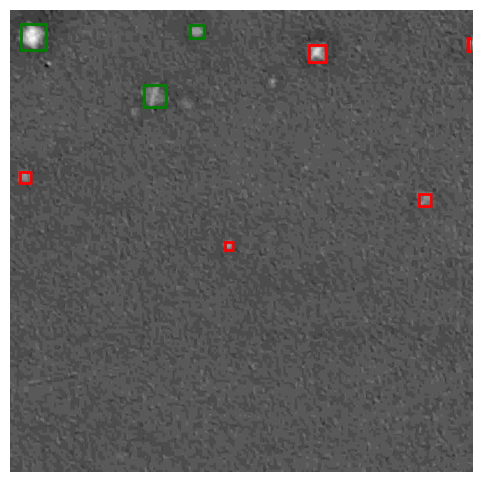

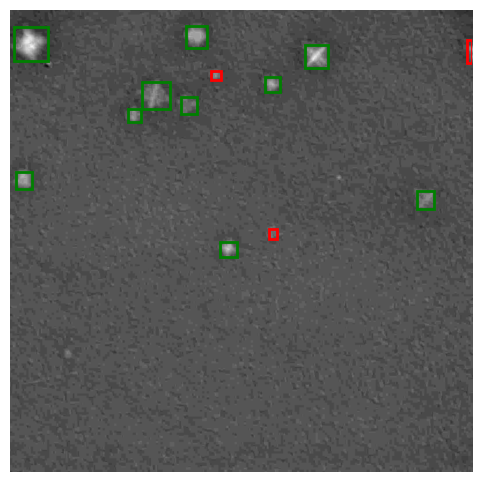

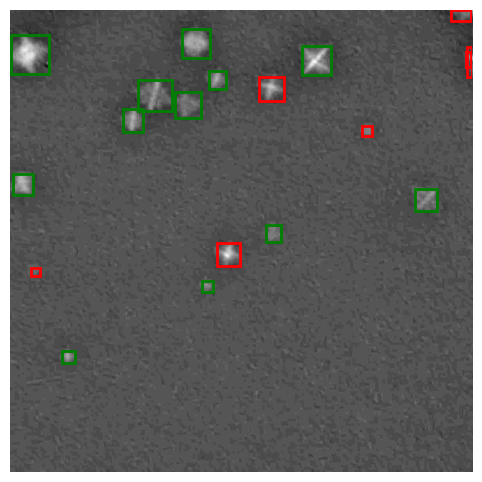

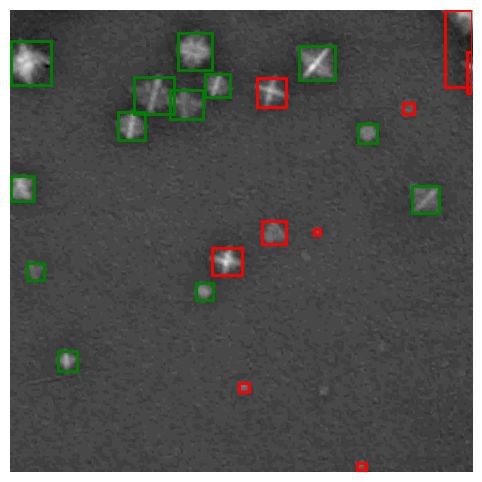

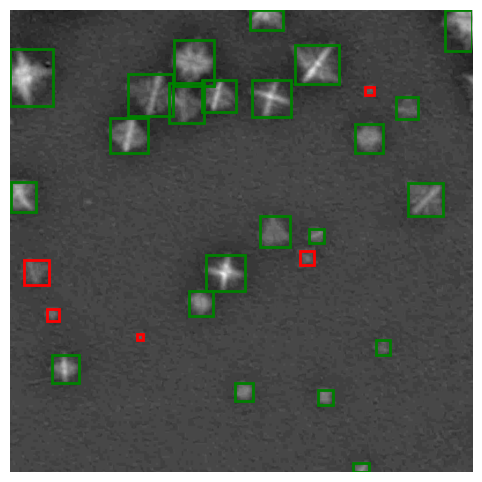

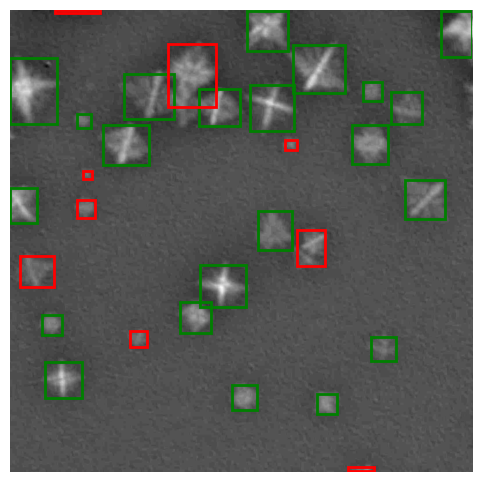

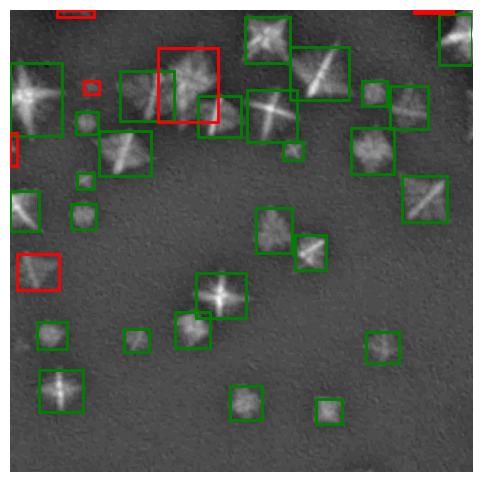

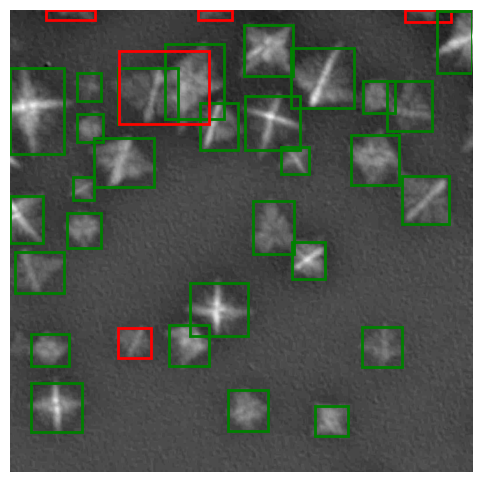

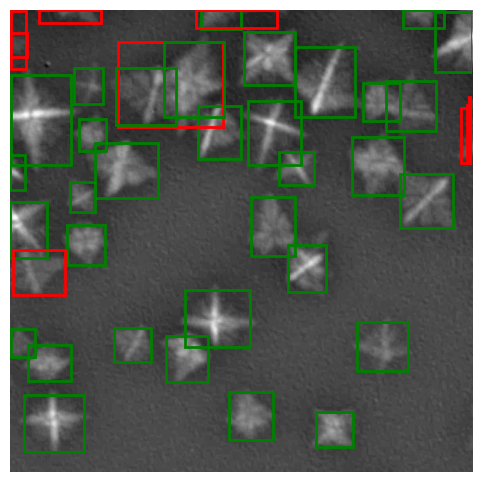

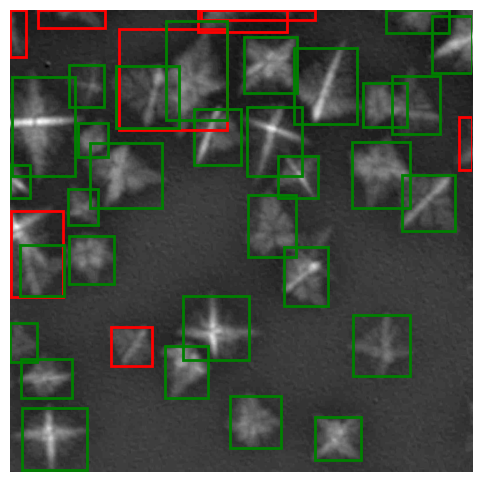

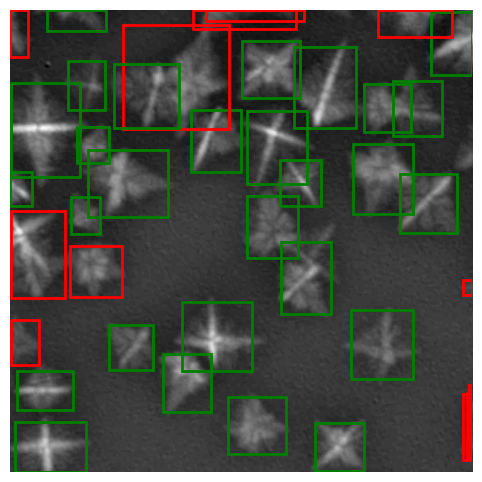

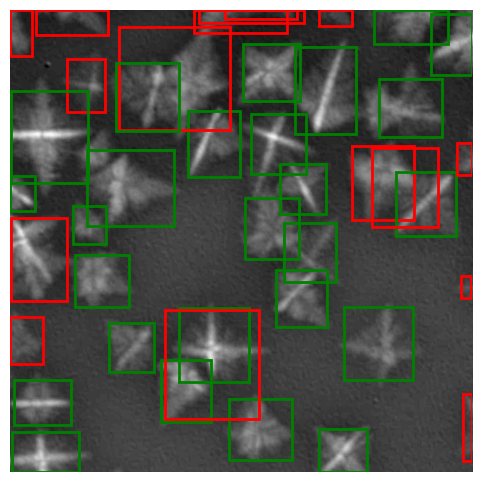

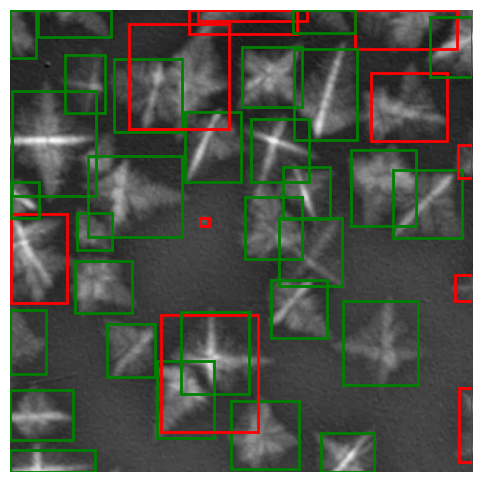

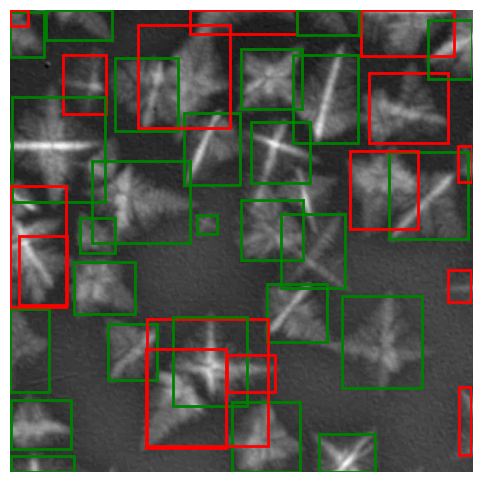

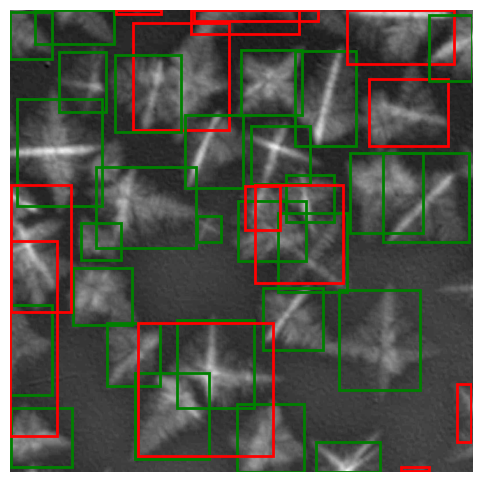

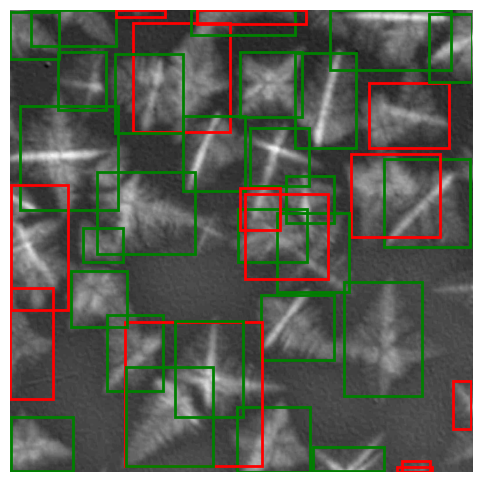

Frames displayed successfully.


In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from dataset import CustomDataset
import numpy as np
import torchvision
import matplotlib.patches as patches
from IPython.display import display, clear_output

# Loading model and dataset

def get_model_instance_segmentation(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

def get_transform(train):
    transforms = []
    if train:
        pass
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth', map_location=device))
model.to(device).eval()

print('model loaded')

annotations_file = "/home/rohit/AIXI/model1_8/1_8_pytorch_annotations_cropped.csv" 
image_dir = "/home/rohit/AIXI/annotated_images_flat_cropped/"
dataset = CustomDataset(annotations_file, image_dir, get_transform(train=False))

print('dataset loaded')
print(len(dataset))

eval_transform = get_transform(train=False)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def plot_predicted_boxes_with_iou(ax, pred_boxes, gt_boxes, labels=None, iou_threshold=0.3):
    matched = [False] * len(pred_boxes)

    for i, pred_box in enumerate(pred_boxes):
        color = 'red'
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                color = 'green'
                matched[i] = True
                break
        
        x, y, x2, y2 = pred_box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(x, y, labels[i], va='bottom', ha='left', color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor=color))

def display_frame(image_path, frame_idx, show_labels=False):
    filename = frame_files[frame_idx]
    image = read_image(image_path)

    img_target = dataset.get_item_by_filename(filename)
    if img_target is None:
        print(f"Skipping {filename} due to missing annotations.")
        return
    
    img, target = img_target

    if img is None or target is None:
        print(f"Skipping {filename} due to missing data.")
        return

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    high_conf_indices = [i for i, score in enumerate(pred['scores']) if score > confidence_threshold]
    high_conf_boxes = pred['boxes'][high_conf_indices].long()
    if show_labels:
        high_conf_labels = [f"grain: {score:.3f}" for score in pred['scores'][high_conf_indices]]
    else:
        high_conf_labels = [''] * len(high_conf_indices)

    fig, ax = plt.subplots(figsize=(12, 6))
    high_conf_boxes = high_conf_boxes.cpu().numpy()
    ax.imshow(img_np, cmap='gray')
    gt_boxes_np = target['boxes'].cpu().numpy()
    plot_predicted_boxes_with_iou(ax, high_conf_boxes, gt_boxes_np, high_conf_labels, iou_threshold=0.5)
    ax.axis('off')
    display(fig)
    plt.close(fig)

experiment_nums = ['040']

for i in experiment_nums:
    experiment_num = i
    confidence_threshold = 0.35

    frame_files = []
    for filename in os.listdir(image_dir):
        if filename.startswith(f'ma2035_{experiment_num}') and filename.lower().endswith('.jpg'):
            frame_files.append(filename)

    frame_files = sorted(frame_files)
    print(f"Number of frames: {len(frame_files)}")

    num_frames = len(frame_files)
    if num_frames < 21:
        print("Not enough frames to select 16 frames starting from the 5th frame.")
        break

    selected_frames = list(range(5, num_frames, max(1, (num_frames - 5) // 15)))[:16]
    print(f"Selected frames: {selected_frames}")

    for idx in selected_frames:
        image_path = os.path.join(image_dir, frame_files[idx])
        display_frame(image_path, idx)

print("Frames displayed successfully.")

model loaded
dataset loaded
9904
Number of frames: 37
Selected frames: [5, 9, 13, 17, 21, 25, 29, 33]


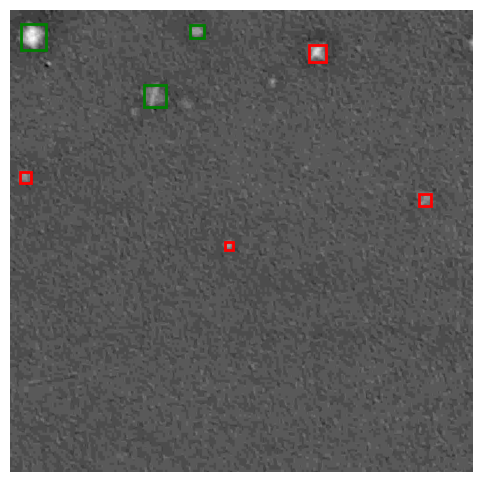

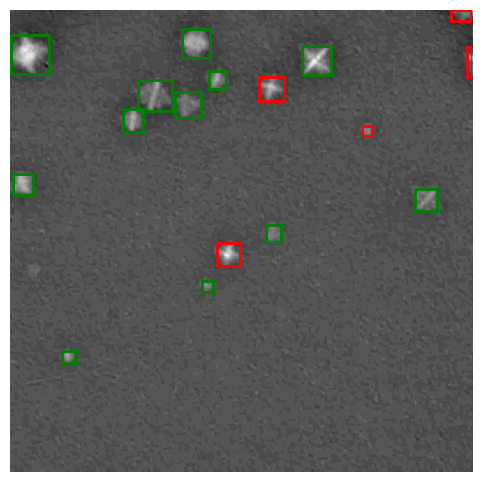

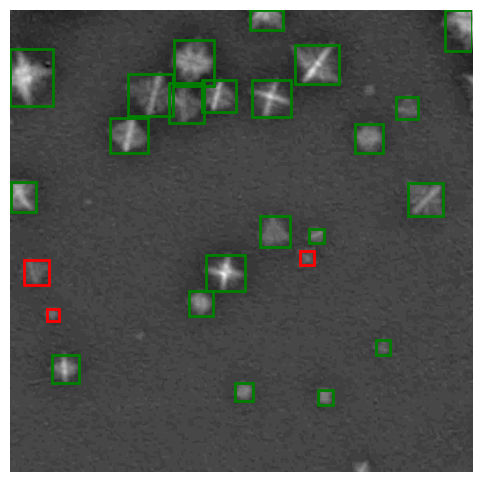

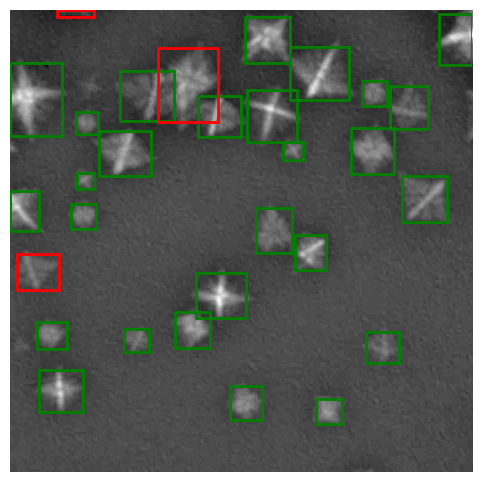

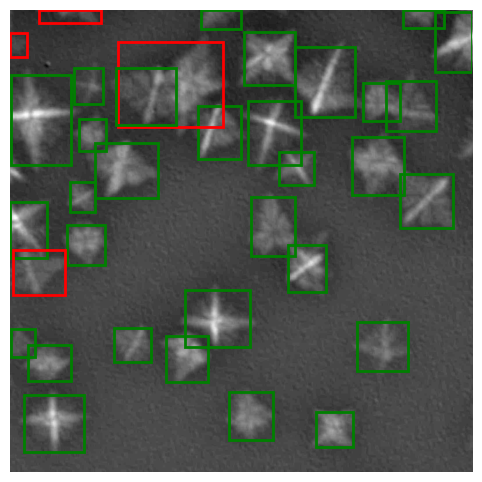

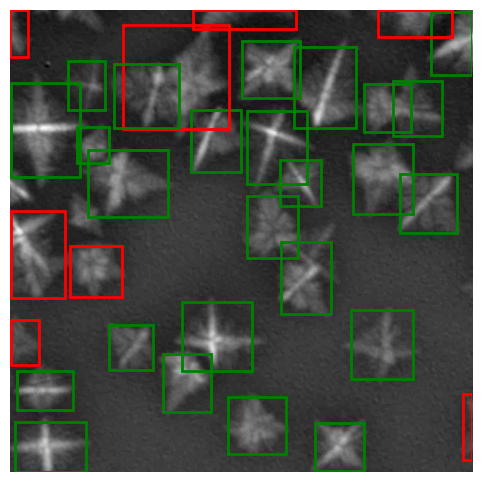

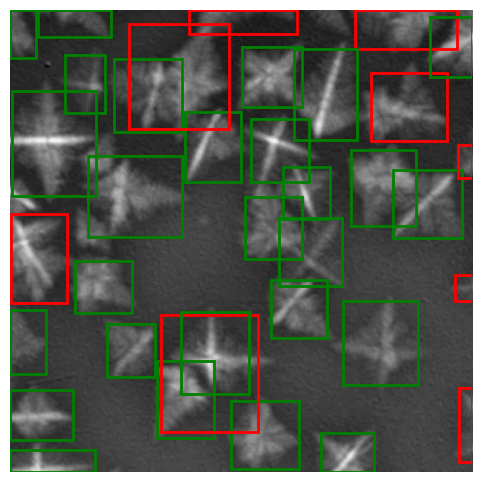

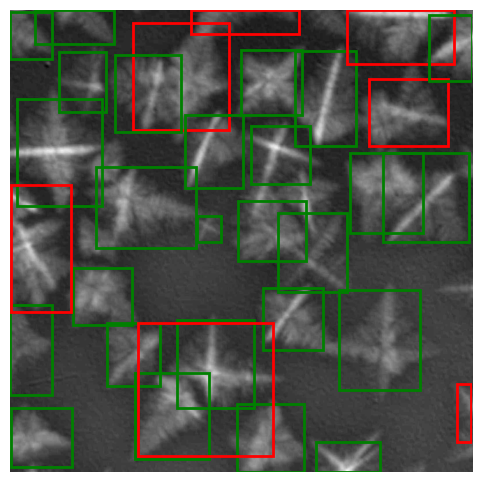

Frames displayed successfully.


In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from dataset import CustomDataset
import numpy as np
import torchvision
import matplotlib.patches as patches
from IPython.display import display, clear_output

# Loading model and dataset

def get_model_instance_segmentation(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

def get_transform(train):
    transforms = []
    if train:
        pass
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth', map_location=device))
model.to(device).eval()

print('model loaded')

annotations_file = "/home/rohit/AIXI/model1_8/1_8_pytorch_annotations_cropped.csv" 
image_dir = "/home/rohit/AIXI/annotated_images_flat_cropped/"
dataset = CustomDataset(annotations_file, image_dir, get_transform(train=False))

print('dataset loaded')
print(len(dataset))

eval_transform = get_transform(train=False)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def plot_predicted_boxes_with_iou(ax, pred_boxes, gt_boxes, labels=None, iou_threshold=0.3):
    matched = [False] * len(pred_boxes)

    for i, pred_box in enumerate(pred_boxes):
        color = 'red'
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                color = 'green'
                matched[i] = True
                break
        
        x, y, x2, y2 = pred_box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(x, y, labels[i], va='bottom', ha='left', color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor=color))

def display_frame(image_path, frame_idx, show_labels=False):
    filename = frame_files[frame_idx]
    image = read_image(image_path)

    img_target = dataset.get_item_by_filename(filename)
    if img_target is None:
        print(f"Skipping {filename} due to missing annotations.")
        return
    
    img, target = img_target

    if img is None or target is None:
        print(f"Skipping {filename} due to missing data.")
        return

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    high_conf_indices = [i for i, score in enumerate(pred['scores']) if score > confidence_threshold]
    high_conf_boxes = pred['boxes'][high_conf_indices].long()
    if show_labels:
        high_conf_labels = [f"grain: {score:.3f}" for score in pred['scores'][high_conf_indices]]
    else:
        high_conf_labels = [''] * len(high_conf_indices)

    fig, ax = plt.subplots(figsize=(12, 6))
    high_conf_boxes = high_conf_boxes.cpu().numpy()
    ax.imshow(img_np, cmap='gray')
    gt_boxes_np = target['boxes'].cpu().numpy()
    plot_predicted_boxes_with_iou(ax, high_conf_boxes, gt_boxes_np, high_conf_labels, iou_threshold=0.5)
    ax.axis('off')
    display(fig)
    plt.close(fig)

experiment_nums = ['040']

for i in experiment_nums:
    experiment_num = i
    confidence_threshold = 0.8

    frame_files = []
    for filename in os.listdir(image_dir):
        if filename.startswith(f'ma2035_{experiment_num}') and filename.lower().endswith('.jpg'):
            frame_files.append(filename)

    frame_files = sorted(frame_files)
    print(f"Number of frames: {len(frame_files)}")

    num_frames = len(frame_files)
    if num_frames < 14:
        print("Not enough frames to select 9 frames starting from the 5th frame.")
        break

    selected_frames = list(range(5, num_frames, max(1, (num_frames - 5) // 8)))[:9]
    print(f"Selected frames: {selected_frames}")

    for idx in selected_frames:
        image_path = os.path.join(image_dir, frame_files[idx])
        display_frame(image_path, idx)

print("Frames displayed successfully.")

model loaded
dataset loaded
9904
Number of frames: 37
Selected frames: [5, 9, 13, 17, 21, 25, 29, 33]


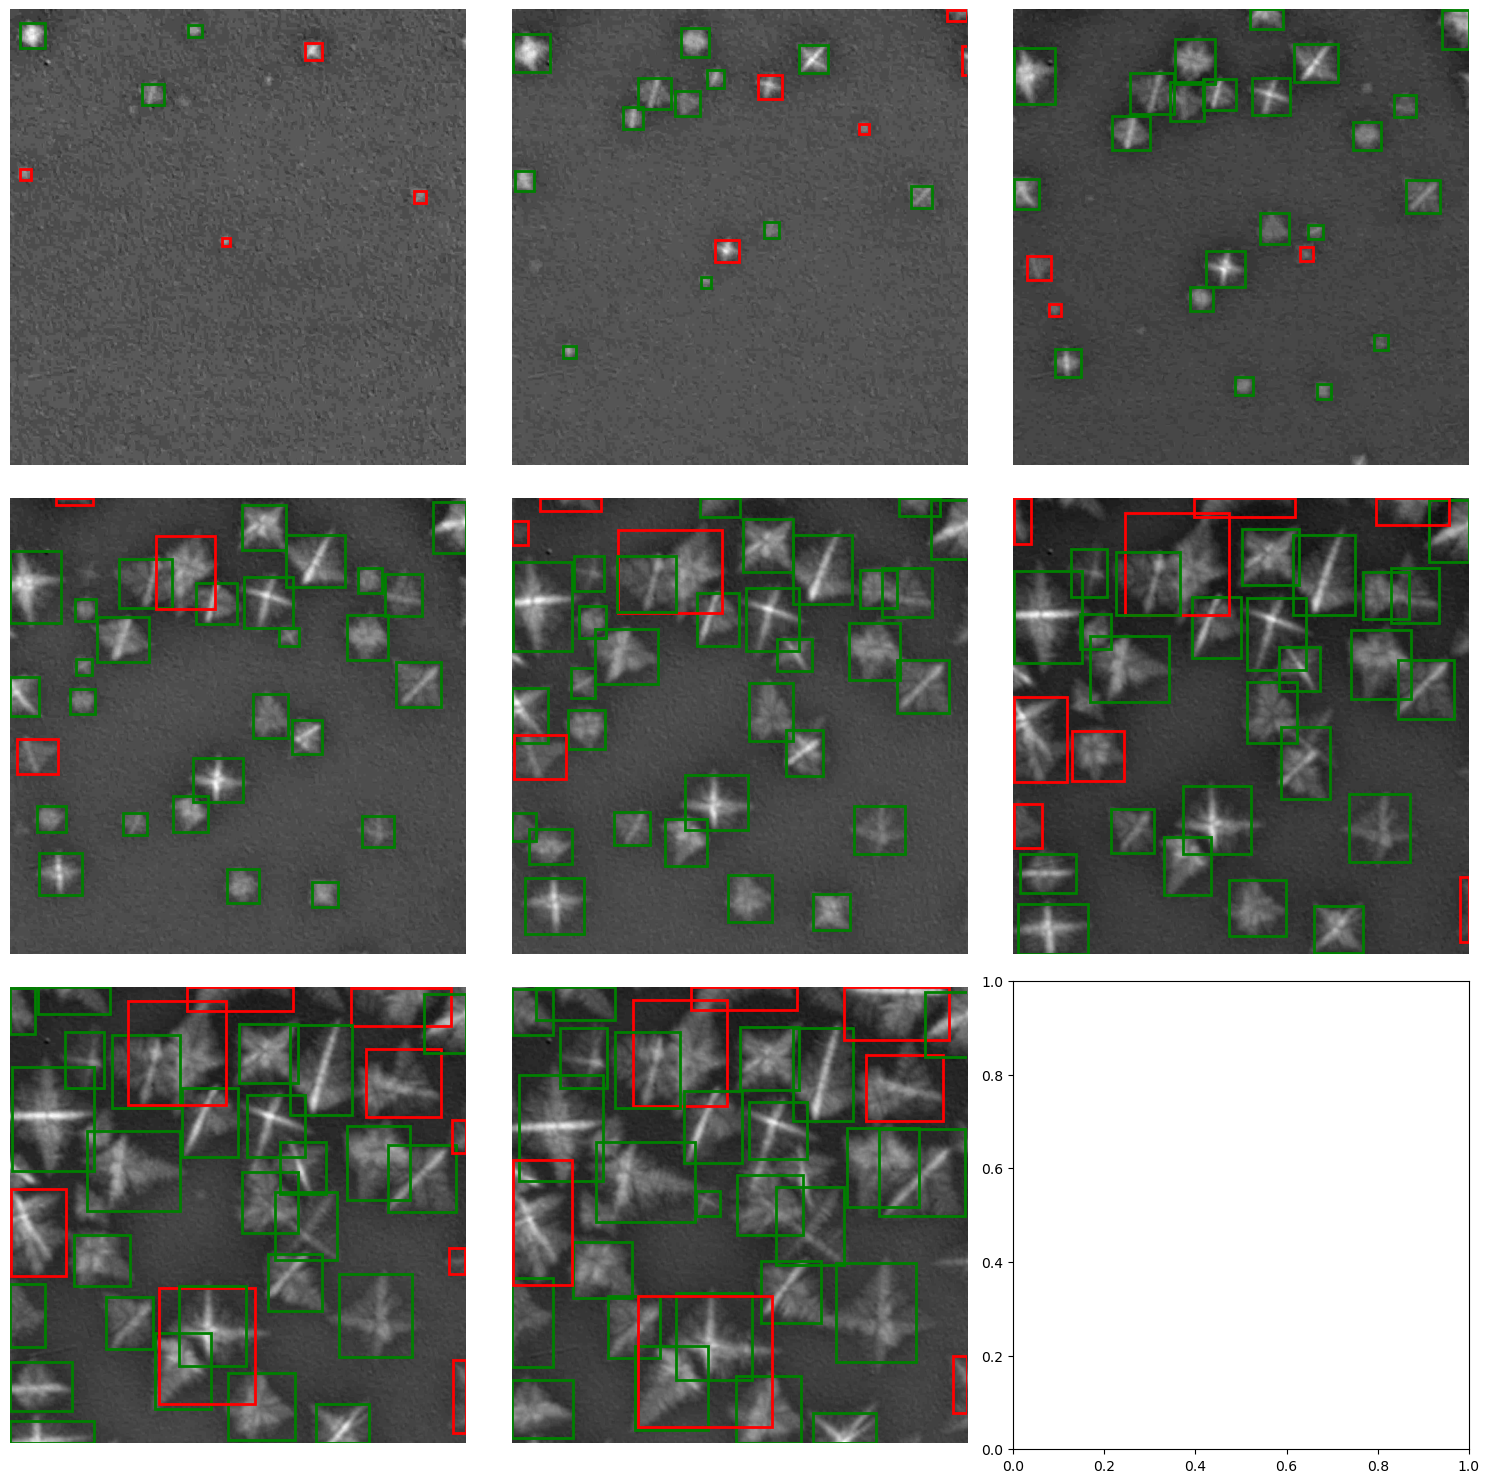

Frames displayed successfully.


In [4]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from dataset import CustomDataset
import numpy as np
import torchvision
import matplotlib.patches as patches

# Loading model and dataset

def get_model_instance_segmentation(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

def get_transform(train):
    transforms = []
    if train:
        pass
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth', map_location=device))
model.to(device).eval()

print('model loaded')

annotations_file = "/home/rohit/AIXI/model1_8/1_8_pytorch_annotations_cropped.csv" 
image_dir = "/home/rohit/AIXI/annotated_images_flat_cropped/"
dataset = CustomDataset(annotations_file, image_dir, get_transform(train=False))

print('dataset loaded')
print(len(dataset))

eval_transform = get_transform(train=False)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def plot_predicted_boxes_with_iou(ax, pred_boxes, gt_boxes, labels=None, iou_threshold=0.3):
    matched = [False] * len(pred_boxes)

    for i, pred_box in enumerate(pred_boxes):
        color = 'red'
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                color = 'green'
                matched[i] = True
                break
        
        x, y, x2, y2 = pred_box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(x, y, labels[i], va='bottom', ha='left', color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor=color))

def display_frame(image_path, frame_idx, ax, show_labels=False):
    filename = frame_files[frame_idx]
    image = read_image(image_path)

    img_target = dataset.get_item_by_filename(filename)
    if img_target is None:
        print(f"Skipping {filename} due to missing annotations.")
        return
    
    img, target = img_target

    if img is None or target is None:
        print(f"Skipping {filename} due to missing data.")
        return

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    high_conf_indices = [i for i, score in enumerate(pred['scores']) if score > confidence_threshold]
    high_conf_boxes = pred['boxes'][high_conf_indices].long()
    if show_labels:
        high_conf_labels = [f"grain: {score:.3f}" for score in pred['scores'][high_conf_indices]]
    else:
        high_conf_labels = [''] * len(high_conf_indices)

    high_conf_boxes = high_conf_boxes.cpu().numpy()
    ax.imshow(img_np, cmap='gray')
    gt_boxes_np = target['boxes'].cpu().numpy()
    plot_predicted_boxes_with_iou(ax, high_conf_boxes, gt_boxes_np, high_conf_labels, iou_threshold=0.5)
    ax.axis('off')

experiment_nums = ['040']

for i in experiment_nums:
    experiment_num = i
    confidence_threshold = 0.8

    frame_files = []
    for filename in os.listdir(image_dir):
        if filename.startswith(f'ma2035_{experiment_num}') and filename.lower().endswith('.jpg'):
            frame_files.append(filename)

    frame_files = sorted(frame_files)
    print(f"Number of frames: {len(frame_files)}")

    num_frames = len(frame_files)
    if num_frames < 14:
        print("Not enough frames to select 9 frames starting from the 5th frame.")
        break

    selected_frames = list(range(5, num_frames, max(1, (num_frames - 5) // 8)))[:9]
    print(f"Selected frames: {selected_frames}")

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for ax, idx in zip(axes, selected_frames):
        image_path = os.path.join(image_dir, frame_files[idx])
        display_frame(image_path, idx, ax)

    plt.tight_layout()
    plt.show()

print("Frames displayed successfully.")

model loaded
dataset loaded
9904
Number of frames: 37
Selected frames: [5, 9, 13, 17, 21, 25, 29, 33]


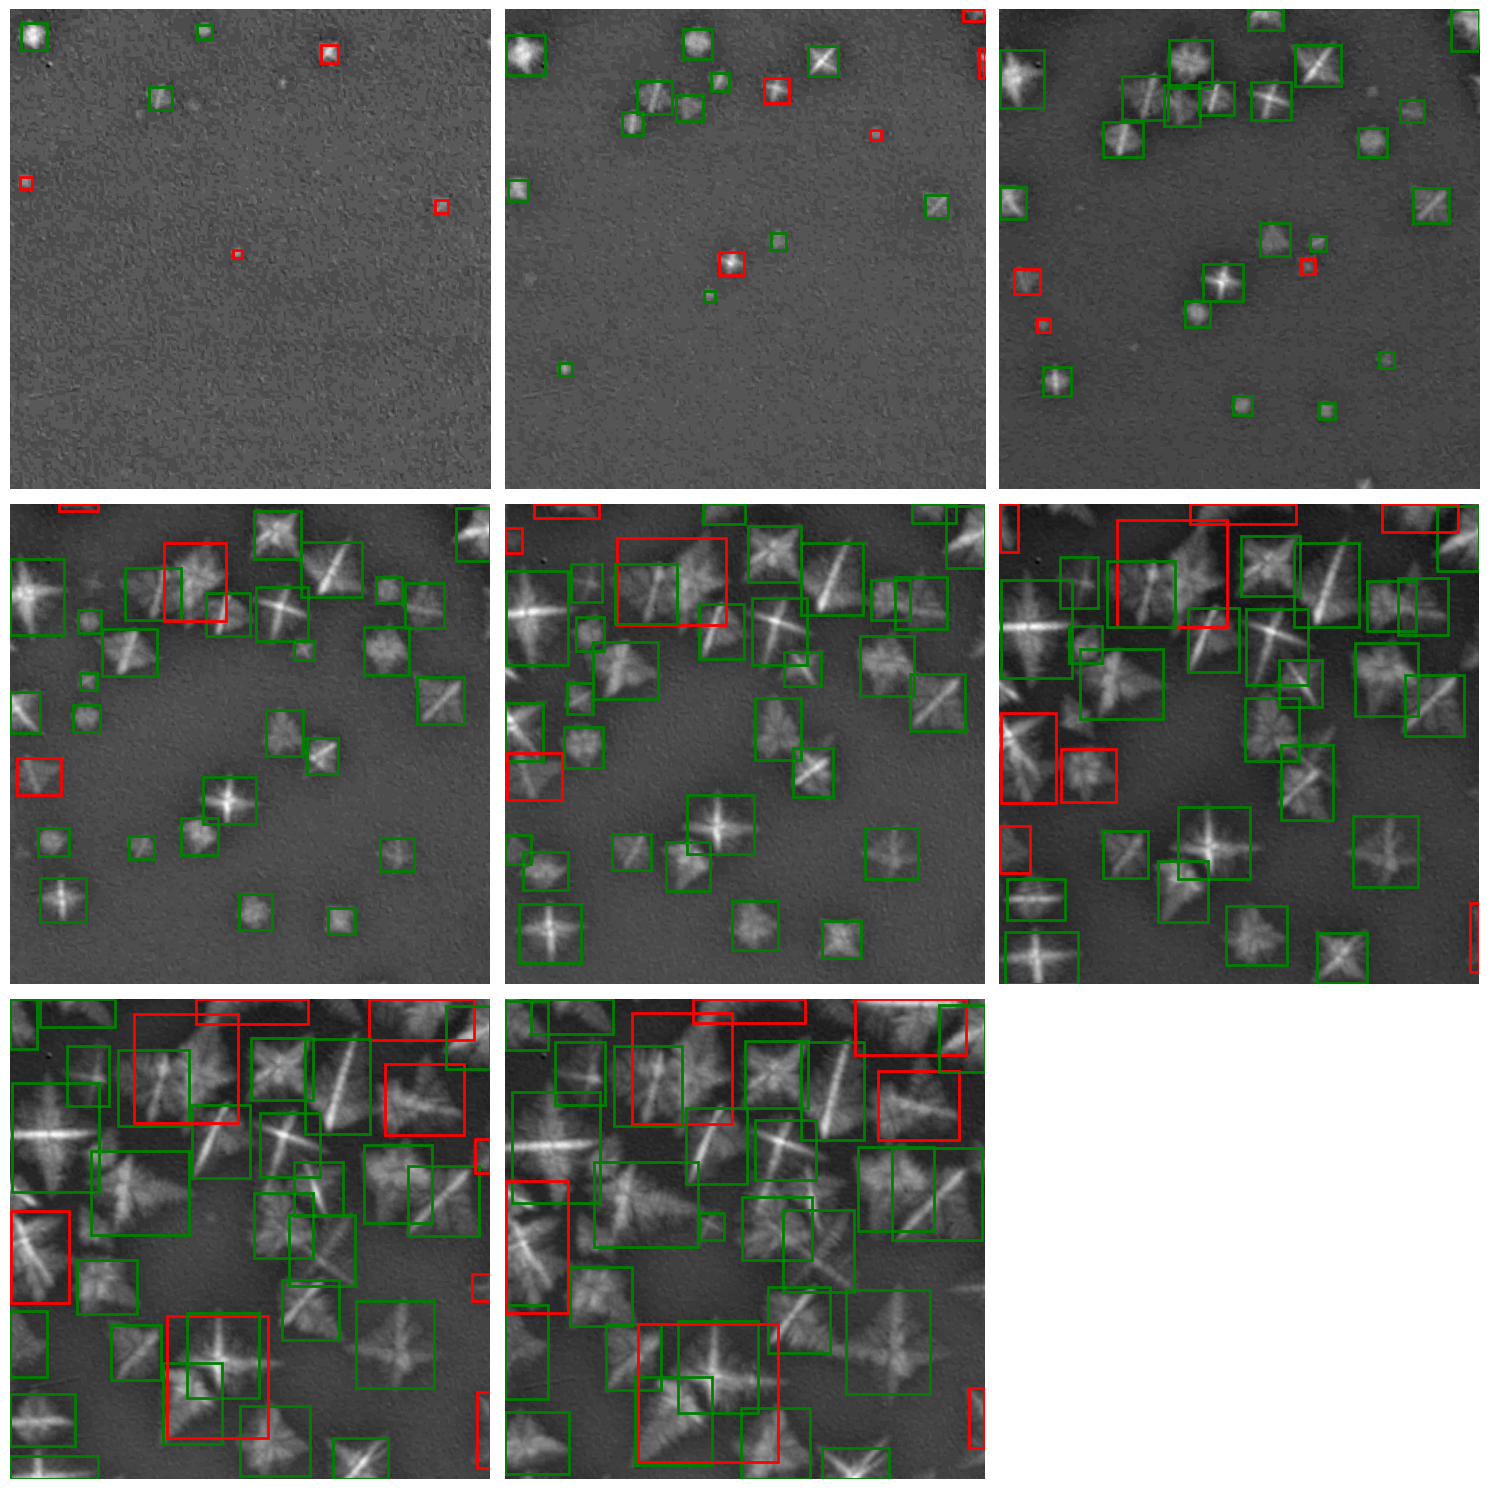

Frames displayed successfully.


In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from dataset import CustomDataset
import numpy as np
import torchvision
import matplotlib.patches as patches

# Loading model and dataset

def get_model_instance_segmentation(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

def get_transform(train):
    transforms = []
    if train:
        pass
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth', map_location=device))
model.to(device).eval()

print('model loaded')

annotations_file = "/home/rohit/AIXI/model1_8/1_8_pytorch_annotations_cropped.csv" 
image_dir = "/home/rohit/AIXI/annotated_images_flat_cropped/"
dataset = CustomDataset(annotations_file, image_dir, get_transform(train=False))

print('dataset loaded')
print(len(dataset))

eval_transform = get_transform(train=False)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def plot_predicted_boxes_with_iou(ax, pred_boxes, gt_boxes, labels=None, iou_threshold=0.3):
    matched = [False] * len(pred_boxes)

    for i, pred_box in enumerate(pred_boxes):
        color = 'red'
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                color = 'green'
                matched[i] = True
                break
        
        x, y, x2, y2 = pred_box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(x, y, labels[i], va='bottom', ha='left', color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor=color))

def display_frame(image_path, frame_idx, ax, show_labels=False):
    filename = frame_files[frame_idx]
    image = read_image(image_path)

    img_target = dataset.get_item_by_filename(filename)
    if img_target is None:
        print(f"Skipping {filename} due to missing annotations.")
        return
    
    img, target = img_target

    if img is None or target is None:
        print(f"Skipping {filename} due to missing data.")
        return

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    high_conf_indices = [i for i, score in enumerate(pred['scores']) if score > confidence_threshold]
    high_conf_boxes = pred['boxes'][high_conf_indices].long()
    if show_labels:
        high_conf_labels = [f"grain: {score:.3f}" for score in pred['scores'][high_conf_indices]]
    else:
        high_conf_labels = [''] * len(high_conf_indices)

    high_conf_boxes = high_conf_boxes.cpu().numpy()
    ax.imshow(img_np, cmap='gray')
    gt_boxes_np = target['boxes'].cpu().numpy()
    plot_predicted_boxes_with_iou(ax, high_conf_boxes, gt_boxes_np, high_conf_labels, iou_threshold=0.5)
    ax.axis('off')

experiment_nums = ['040']

for i in experiment_nums:
    experiment_num = i
    confidence_threshold = 0.8

    frame_files = []
    for filename in os.listdir(image_dir):
        if filename.startswith(f'ma2035_{experiment_num}') and filename.lower().endswith('.jpg'):
            frame_files.append(filename)

    frame_files = sorted(frame_files)
    print(f"Number of frames: {len(frame_files)}")

    num_frames = len(frame_files)
    if num_frames < 14:
        print("Not enough frames to select 9 frames starting from the 5th frame.")
        break

    selected_frames = list(range(5, num_frames, max(1, (num_frames - 5) // 8)))[:9]
    print(f"Selected frames: {selected_frames}")

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for ax, idx in zip(axes, selected_frames):
        image_path = os.path.join(image_dir, frame_files[idx])
        display_frame(image_path, idx, ax)

    for j in range(len(selected_frames), 9):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

print("Frames displayed successfully.")